## В классе
Придумать спецификацию класса агента – игрока

In [1]:
WEIGHT_FROM_FILE = True
p = 0.1
alpha = 0.5
percentage = 0.2
bound = 0.01
update_before_rndom_move = True

In [2]:
class AgentTicTac:
    def __init__(self, is_zero):
    #is_zero == True если нолик
        self.is_zero = is_zero
        self.label = int(not is_zero)
        self.way = []
        if WEIGHT_FROM_FILE:
            self.state_matrix = pd.read_csv('weight{}.csv'.format(self.label), dtype={'states': object}).set_index('states')
            self.state_matrix['possible_moves'] = self.state_matrix['possible_moves'].apply(lambda x: ast.literal_eval(x))
        else:
            self.state_matrix = state_generate(self.is_zero)
    def get_action(self, state):
    # пример state = [[1,0,1],[0,1,0],[0,1,0]] 1 - это крестик, 0 - это нолик, -1 - пусто
        now_state = self.state_matrix.loc[get_code_from_state(state)]
        pos_move = pd.DataFrame(now_state['possible_moves'])
        if np.random.random() < p:
            new_state = pos_move.sample(n = 1).iloc[0]
            new_state_value = self.state_matrix.loc[new_state['state'], 'value']
            self.way.append(((now_state.name, now_state.value), (new_state['state'], new_state_value)))
            #self.state_matrix.loc[get_code_from_state(state), 'value'] = now_state['value'] + alpha*(new_state_value -
            #                                                                                         now_state['value'])
            return new_state['move']
        else:
            pos_move['value'] = pos_move['state'].apply(lambda x: self.state_matrix.loc[x, 'value'])
            new_state = pos_move[pos_move['value']==pos_move['value'].max()].iloc[0]
            new_state_value = self.state_matrix.loc[new_state['state'], 'value']
            self.way.append(((now_state.name, now_state.value), (new_state['state'], new_state_value)))
            #self.state_matrix.loc[get_code_from_state(state), 'value'] = now_state['value'] + alpha*(new_state['value'] -
            #                                                                                         now_state['value'])
            return new_state['move']
    def save_weight(self):
        self.state_matrix.to_csv('weight{}.csv'.format(self.label))
    def is_done(self, state, reward):
        if reward == 1:
            for move in self.way[::-1]:
                self.state_matrix.loc[move[0][0], 'value'] = move[0][1] + alpha*(move[1][1] -move[0][1])
    # reward - вознаграждение 1 если выиграли , вызывается когда игра закончена
        
class AgentTicTac_e:
    def __init__(self, is_zero, inheritance, parent_weights):
    #is_zero == True если нолик
        self.is_zero = is_zero
        self.label = int(not is_zero)
        if inheritance:
            self.state_matrix = change_states_val(parent_weights, percentage, bound)
        else:
            if WEIGHT_FROM_FILE:
                self.state_matrix = pd.read_csv('weight_e{}.csv'.format(self.label), dtype={'states': object}).set_index('states')
                self.state_matrix['possible_moves'] = self.state_matrix['possible_moves'].apply(lambda x: ast.literal_eval(x))
            else:
                self.state_matrix = state_generate_evolut(self.label)
    def get_action(self, state):
        now_state = self.state_matrix.loc[get_code_from_state(state)]
        pos_move = pd.DataFrame(now_state['possible_moves'])
        pos_move['value'] = pos_move['state'].apply(lambda x: self.state_matrix.loc[x, 'value'])
        new_state = pos_move[pos_move['value']==pos_move['value'].max()].iloc[0]
        return new_state['move']
    def save_weight(self):
        self.state_matrix.to_csv('weight_e{}.csv'.format(self.label))
    def is_done(self, state, reward):
        return 0
        

## Дома
Написать класс, который берет два экземпляра классов агентов и играет

Реализовать игроков на на основе обучения с подкреплением и эволюционного подхода

Поведём состязание

Проверить: как лучше – корректировать ценности после всех ходов или только "жадных"?

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast

In [4]:
#проверка победы
def check_win(state, label):
    for i in range(3):
        if np.all(state[i,:] == int(label)):
            return True
        elif np.all(state[:,i] == int(label)):
            return True
    if np.all(np.fliplr(state).diagonal() == int(label)):
        return True
    if np.all(state.diagonal() == int(label)):
        return True
    return False

#вывод поля состояния в виде матрицы
def get_state_from_code(code):
    return np.array(re.findall(r'\d', code)).reshape((3,3)).astype('int')-1

#
def get_code_from_state(state):
    result = ''
    for s in (state.flatten()+1).astype('str'):
        result += s
    return result


## функция выбора след.хода

скопировала твой гениратор и добавила своего кода, поправь пожалст, а то прям видно что писал недопрограммист))

In [5]:
#получаем индексы свободных полей
def get_free_field(state):
    index = []
    for i in range(3):
        for j in range(3):
            if state[i][j]==-1:
                index.append((i,j))
    return index

In [6]:
#получение списка следующих возможных ходов
def get_possible_state(state, label):
    pos_state = []
    index = get_free_field(state)
    for i,j in index:
        s=state
        s[i][j]=label
        pos_state.append(get_code_from_state(s))
    return pos_state

In [7]:
#следующие возможные ходы, может я твой код не так понял, но у меня он что-то странное выдавал
def get_possible_move_from_code(state, label):
    label = str(int(label)+1)
    states = {'state':[], 'move':[]}
    for i in range(len(state)):
        if state[i]=='0':
            states['state'].append(state[:i]+label+state[i+1:])
            states['move'].append(((i)//3,i%3))
    return states

In [8]:
#генирация состояний со следующими ходами
#гениратор состояний
def state_generate(label):
    states = []
    values = []
    for i in range(19683):
        s = np.base_repr(i,base=3)
        s = '0'*(9-len(s)) + s
        states.append(s)
        if check_win(get_state_from_code(s), label):
            values.append(1)
        else:
            values.append(0.5)
    states = np.array(states)
    pos_st = []
    for state_code in states:
        pos_st.append(get_possible_move_from_code(state_code, label))
    return pd.DataFrame({'states':states, 'value':values,'possible_moves':pos_st}).set_index('states')

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
#проведение 1 раунда
def two_came_in_one_came_out(agent_zeros, agent_ones, print_state = False):
    state = (np.zeros((3,3))-1).astype('int')
    while -1 in state:
        #ход креста
        state[agent_ones.get_action(state)] = 1
        if print_state:
            print(state)
            print()
        if check_win(state, 1):
            agent_ones.is_done(state, True)
            agent_zeros.is_done(state, False)
            return 1
        if not(-1 in state):
            break
        state[agent_zeros.get_action(state)] = 0
        if print_state:
            print(state)
            print()
        if check_win(state, 0):
            agent_ones.is_done(state, False)
            agent_zeros.is_done(state, True)
            return 0
    agent_ones.is_done(state, False)
    agent_zeros.is_done(state, False)
    return -1
def fit(agent_zeros, agent_ones, epochs, step_per_epoch, save_config = False, plot_win = False):
    history = {
        'epoch':[],
        'zeros win':[],
        'ones win':[],
        'draw':[]
    }
    for epoch in tqdm(np.arange(epochs)):
        z_win = 0
        o_win = 0
        draw = 0
        for step in np.arange(step_per_epoch):
            play_result = two_came_in_one_came_out(agent_zeros, agent_ones)
            if play_result == 0:
                z_win += 1
            elif play_result == 1:
                o_win += 1
            else:
                draw += 1
        history['epoch'].append(epoch)
        history['zeros win'].append(z_win)
        history['ones win'].append(o_win)
        history['draw'].append(draw)
    history = pd.DataFrame(history)
    if plot_win:
        plt.figure(figsize=(10, 8))
        plt.plot(history['epoch'], (history['zeros win']/step_per_epoch)*100, 'b-', label = '% побед нуля в эпохе')
        plt.plot(history['epoch'], (history['ones win']/step_per_epoch)*100, 'r-', label = '% побед креста в эпохе')
        plt.plot(history['epoch'], (history['draw']/step_per_epoch)*100, 'k--', label = '% ничей в эпохе')
        plt.xlim([0,epochs])
        plt.ylim([0,101])
        plt.grid()
        plt.legend()
        plt.show()
    if save_config:
        agent_ones.save_weight()
        agent_zeros.save_weight()

In [26]:
zeros = AgentTicTac(True)
ones = AgentTicTac(False)
fit(zeros, ones, epochs = 100, step_per_epoch = 100, save_config = True, plot_win = True)

  1%|          | 1/100 [00:07<12:16,  7.44s/it]

KeyboardInterrupt: 

## Эволюционный подход. Функции

In [11]:
#Начальная инициализация
#Случайное распределение весов у стратегий
import numpy as np
#генирация состояний со следующими ходами
#гениратор состояний
def state_generate_evolut(label):
    states = []
    values = []
    for i in range(19683):
        s = np.base_repr(i,base=3)
        s = '0'*(9-len(s)) + s
        states.append(s)
        if check_win(get_state_from_code(s), label):
            values.append(1)
        else:
            values.append(np.random.sample())
    states = np.array(states)
    pos_st = []
    for state_code in states:
        pos_st.append(get_possible_move_from_code(state_code, label))
    return pd.DataFrame({'states':states, 'value':values,'possible_moves':pos_st}).set_index('states')

In [58]:
s = state_generate(False)
s.head()

,value,possible_moves
states,,
000000000,0.495245,"{'state': ['100000000', '010000000', '00100000..."
000000001,0.565389,"{'state': ['100000001', '010000001', '00100000..."
000000002,0.368132,"{'state': ['100000002', '010000002', '00100000..."
000000010,0.489431,"{'state': ['100000010', '010000010', '00100001..."
000000011,0.176905,"{'state': ['100000011', '010000011', '00100001..."


In [46]:
s.index[1]

'000000001'

In [14]:
# типо изменение весов
#perc – доля объектов, которые надо изменить
def change_states_val(state_tab, perc, bound):
    state_table = state_tab.copy()
    
    rows_cnt = round(state_table.shape[0] * perc,)
    ind_ch = np.random.randint(0, state_table.shape[0], rows_cnt)
    for i in ind_ch:
        state_table.loc[state_table.index[i],'value'] = (state_table.loc[state_table.index[i],'value'] 
                                                +(np.random.random() - .5)*2*bound)
    return state_table

In [64]:
change_states_val(s, 0.7, 0.1).head()

,value,possible_moves
states,,
000000000,0.495245,"{'state': ['100000000', '010000000', '00100000..."
000000001,0.565389,"{'state': ['100000001', '010000001', '00100000..."
000000002,0.358774,"{'state': ['100000002', '010000002', '00100000..."
000000010,0.489431,"{'state': ['100000010', '010000010', '00100001..."
000000011,0.083735,"{'state': ['100000011', '010000011', '00100001..."


### Наследование

Родитель

In [39]:
ev_agent_zeros = AgentTicTac_e(is_zero = True, inheritance = False, parent_weights = False)

In [40]:
ev_agent_zeros.state_matrix.head()

,value,possible_moves
states,,
000000000,0.750208,"{'state': ['100000000', '010000000', '00100000..."
000000001,0.573348,"{'state': ['100000001', '010000001', '00100000..."
000000002,0.130825,"{'state': ['100000002', '010000002', '00100000..."
000000010,0.731153,"{'state': ['100000010', '010000010', '00100001..."
000000011,0.515325,"{'state': ['100000011', '010000011', '00100001..."


Потомок

In [41]:
son_zeros = AgentTicTac_e(is_zero = ev_agent_zeros.is_zero, inheritance = True,  parent_weights = ev_agent_zeros.state_matrix)

In [47]:
((son_zeros.state_matrix == ev_agent_zeros.state_matrix)==False).sum()['value']/son_zeros.state_matrix.shape[0]

0.18046029568663313

18% параметров потомка отличаются от родителя (максимум задан гиперпараметром)

In [12]:
def get_pinnacle_of_evolution(label, size_of_population, epochs, step_per_epochs, is_rival, rival_agent):
    #rival может быть задан изначально, тогда агенты будут тестироваться на нем. Возвращается 1 агент
    #Иначе создается две популяции с 0 и Х, возвращается два лучших агента
    if is_rival:
        #Начальная популяция
        #[[agent, %побед], [agent, %побед],...]
        population = [[AgentTicTac_e(is_zero = not(label), inheritance = False, parent_weights = False),
                       0] for _ in range(size_of_population)]
        for epoch in tqdm(range(epochs)):
            #каждый играет с заданным соперником step_per_epochs раз
            #two_came_in_one_came_out возвращает label победителя, если это label популяции, то эволюционный агент победил
            for i in range(size_of_population):
                win_i = 0
                if label == 0:
                    for _ in range(step_per_epochs):
                        win_i += int(two_came_in_one_came_out(population[i][0], rival_agent, print_state = False)==label)
                else:
                    for _ in range(step_per_epochs):
                        win_i += int(two_came_in_one_came_out(rival_agent, population[i][0], print_state = False)==label)
                population[i][1] = (win_i/step_per_epochs)*100
            #отбираем 50% лучших
            selection_limit = pd.Series([agent_score[1] for agent_score in population]).quantile(0.5)
            agent_id = 0
            while agent_id < len(population):
                if population[agent_id][1] < selection_limit:
                    del population[agent_id]
                else:
                    agent_id += 1
            #генерируем потомков
            new_pop = []
            for agent_score in population:
                new_pop.append([
                    AgentTicTac_e(is_zero = agent_score[0].is_zero, inheritance = True,
                                  parent_weights = agent_score[0].state_matrix),
                    0
                ])
            population = population + new_pop
        best_score = pd.Series([agent_score[1] for agent_score in population]).max()
        for agent_score in population:
            if agent_score[1] == best_score:
                return agent_score[0]

In [64]:
ev_agent = get_pinnacle_of_evolution(1, size_of_population=100, epochs=20,
                                     step_per_epochs=50, is_rival=True, rival_agent=zeros)


  0%|                                                   | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Игра с Кириллом

In [27]:
import Kir_agent

In [13]:
class Game:
    
    def __init__(self, field=None):
        self.field = None
        
        if field:
            self.field = field
        else:
            self.start()
    
    def start(self):
        self.field = [' ']*9

    def printField(self):
        row = ''
        for i in range(len(self.field)):
            cell = self.field[i]
            row+='['
            if cell != ' ':
                row+=cell
            else:
                row+=str(i+1)
            row+=']'
            if (i % 3 == 2): 
                print(row)
                row = ''
    
    def set(self, position, side):
        pos = int(position)-1
        self.field[pos] = side

    def getFree(self):
        free = []
        for i in range(len(self.field)):
            cell = self.field[i]
            if (cell == ' '):
                free.append( (i+1) )
        return free
    
    def isDraw(self):
        free = self.getFree();
        return len(free)==0;

    def isWin(self, side):
        for i in range(3):
            isW = True 
            for j in range(3):
                if self.field[i*3+j]!=side:
                    isW = False
                    break
            if isW:
                return isW
            
        for i in range(3):
            isW = True 
            for j in range(3):
                if self.field[j*3+i]!=side:
                    isW = False
                    break
            if isW:
                return isW
            
        isW = True;
        for i in range(3):
            if self.field[i*3+i]!=side:
                isW = False
                break
        if isW:
            return isW
        
        isWi = True;
        for i in range(3):
            if self.field[(i*3+2-i)]!=side:
                isW = False
                break
        if isW:
            return isW

        return False

    def getState(self, side):
        if side == 'x':
            return self.field

        newField = ''
        for i in range(len(self.field)):
            if self.field[i]=='x':
                newField += 'o'
            elif self.field[i]=='o':
                newField += 'x'
            else:
                newField += self.field[i] 

        return newField

In [14]:
import os
import json

class AI:
    def __init__(self):
        self.table = {}
        if os.path.isfile('./rewards.json'):
            with open('rewards.json') as json_file:
                self.table = json.load(json_file)
                print("loaded AI from rewards.json")

    def getReward(self, state):
        game = Game(state)
        
        #если победитель - мы, то оценка состояния игры "1"
        if game.isWin('x'):
            return 1

        #если победиль - соперник, то оценка состояния игры "0"
        if game.isWin('o'):
            return 0

        #смотрим ценность по таблице
        strstate = ''.join(state)
        if strstate in self.table.keys():
            return self.table[strstate]

        #если в таблице нет, то считаем начальной ценностью "0.5"
        return 0.5

    def correct(self, state, newReward):
        oldReward = self.getReward(state)
        strstate = ''.join(state)
        self.table[strstate] = oldReward + 0.1 * (newReward - oldReward)

    def save(self):
        with open('rewards.json', 'w') as outfile:
            json.dump(self.table, outfile)

In [15]:
import random 
import copy

class AIPlayer:
    
    def __init__(self, side, ai, isGreedy=True):
        self.side = side
        self.ai = ai
        self.oldState = None
        self.isGreedy = isGreedy

    def getSide(self):
        return self.side

    def makeStep(self, game):
        #получаем список доступных ходов
        free = game.getFree()
        
        #решаем, является ли текущий ход 
        #зондирующим (случайным) или жадным (максимально выгодным)
        
        if not self.isGreedy:
            #случайный ход
            print('Random step')
            step = random.choice(free)
            game.set(step, self.side)
            self.oldState = game.getState(self.side)
            return step

        #жадный ход
        rewards = {}
        for step in free:
            # для каждого доступного хода оцениваем состояние игры после него
            newGame = copy.deepcopy(game)
            newGame.set(step, self.side)
            rewards[step] = self.ai.getReward(newGame.getState(self.side))

        #выясняем, какое вознаграждение оказалось максимальным
        maxReward = 0
        for reward in rewards.values():
            if reward > maxReward:
                maxReward = reward

        #находим все шаги с максимальным вознаграждением
        steps = []
        
        for step in rewards:
            reward = rewards[step]
            if (maxReward > (reward - 0.01)) and (maxReward < (reward + 0.01)):
                steps.append(step)

        #корректируем оценку прошлого состояния
        #с учетом ценности нового состояния
        if (self.oldState):
            self.ai.correct(self.oldState, maxReward)

        #выбираем ход из ходов с максимальный вознаграждением
        step = random.choice(steps)
        game.set(step, self.side)

        #сохраняем текущее состояние для того, 
        #чтобы откорректировать её ценность на следующем ходе
        self.oldState = game.getState(self.side)
        return step

    def loose(self):
        #корректируем ценность предыдущего состояния при проигрыше
        if self.oldState:
            self.ai.correct(self.oldState, 0)

    def win(self):
        #корректируем ценность предыдущего состояния при выигрыше
        if self.oldState:
            self.ai.correct(self.oldState, 1)
    
    def draw(self):
        #корректируем ценность предыдущего состояния при ничьей
        if self.oldState:
            self.ai.correct(self.oldState, 0.5)

In [16]:
class UserPlayer:

    def __init__(self, side):
        self.side = side

    def getSide(self):
        return self.side

    def makeStep(self, game):
        game.printField()
        
        free = game.getFree()

        inp = None
        while (True):
            inp = input()
            if int(inp) in free:
                break
        
        game.set(inp, self.side)

    def loose(self):
        print('you loose')

    def win(self):
        print('you win')

    def draw(self):
        print('draw')

In [17]:
def state_to_gmstate(state):
    """
    Переводим состояние игры из формата массива в формат строки,
    который используется игрой
    """
    gmstate = []
    for row in state:
        for ch in row:
            if ch == -1:
                gmstate.append(' ')
            elif ch == 1:
                gmstate.append('x')
            else:
                gmstate.append('o')
    return gmstate
def gmstep_to_step(step):
    """
    Переводим обозначение хода из принятого в игре 
    в формат который ожидается на выходе агента
    """
    steps = {
        1:(1,1),
        2:(1,2),
        3:(1,3),
        4:(2,1),
        5:(2,2),
        6:(2,3),
        7:(3,1),
        8:(3,2),
        9:(3,3),
    }
    return (steps[step][0]-1,steps[step][1]-1)

In [18]:
class AgentTicTacGreedy:
  def __init__(self, is_zero):
    #is_zero == True если нолик
    self.player = None
    ai = AI()
    if is_zero:
        self.player = AIPlayer('o', ai, True)
    else:
        self.player = AIPlayer('x', ai, True)

  def get_action(self, state):
    # пример state = [[1,0,1],[0,1,0],[0,1,0]] 1 - это крестик, 0 - это нолик, -1 - пусто
    gmstate = state_to_gmstate(state)
    game = Game(field=gmstate)
    move = self.player.makeStep(game)
    return gmstep_to_step(move) # возвращаем координаты хода

  def is_done(self, state, reward):
    # reward - вознаграждение 1 если выиграли , вызывается когда игра закончена
    gmstate = state_to_gmstate(state)
    game = Game(field=gmstate)
    return game.isWin(self.player.getSide())
    


100%|██████████████████████████████████████████| 20/20 [22:45<00:00, 73.86s/it]

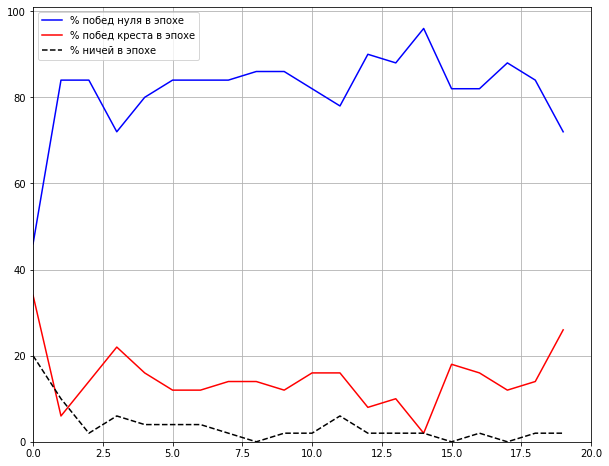

In [20]:
zeros = AgentTicTac(True)
ones = AgentTicTacGreedy(False)
fit(zeros, ones, epochs = 20, step_per_epoch = 50, save_config = False, plot_win = True)

Видно, что наша модель стабильно обыгрывает модель "Кирилл". Случайность в % побед зависит от вероятности сделать "разведывательный ход"<br><br>
Исследуем зависимость % побед от вероятности разведывательного хода